# Data Sciense Flow

###1. Target formulation

###2. Wikipedia parsing

###3. Text cleaning

###4. Model building

###5. Results using


# Articles similarity

<img src="cub.png", style="max-width:90%; width: 40%">

# Wikipedia 

### https://dumps.wikimedia.org/enwiki/latest/ - ~12 Gb size;  ~5 Million articles.

<img src="wiki_wrong.png">

In [2]:
from os.path import isfile, join

import os
import bz2
import itertools

import sys
import time
import re


def text_selecting(part_data, path_to_output_file):
    
    # define variables
    a = []
    text_item = 0
    
    # iterate through articles
    for item in part_data.split("</page>"):
        
        title = item[item.find('<title>')+len('<title>'):item.rfind('</title>')]  # title extracting 
        title = re.sub(r'[^\w\s]', '_', title) # title cleaning
        
        if "<text" in item:
            text_item = item [ item.find("<text")+len("<text") : item.find("</text>")] # article text selecting
            
        # articles writing
        outfilename = path_to_output_file + title + ".txt" # open empty file with title as a name
        
        try:
            with open(outfilename, 'wb') as outfile:     
                outfile.write(title + "\n" + text_item) # write an article 
        except:
            
            pass

        
def split_bzfile(filename, path, path_to_output_file):
    
    startTime = time.time()
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    # counters defining
    pagecount = 0
    filecount = 1
    
    chunkname = lambda filecount: os.path.join(path,"chunk-"+str(filecount)+".xml.bz2")
    chunkfile = bz2.BZ2File(chunkname(filecount), 'w')
    
    print '-'*50 + '\n--------------------Read BZ2 file ------------------\n' + '-'*50
    # open wikipedia dump 
    bzfile = bz2.BZ2File(filename)
    
    # iterate through wikipedia dump lines
    for line in bzfile:      

        
        # process the part of bz2 until 15000 pages
        
        chunkfile.write(line) # write each line to file
        
        if '</page>' in line:  # count the number of pages         
            pagecount += 1
            
        if pagecount > 14999:  # if the number of pages is 15K        
            

            chunkfile = bz2.BZ2File(chunkname(filecount), 'rb') # read part of data
            
            part_data = chunkfile.read() 
            
            
        
            data = text_selecting(part_data, path_to_output_file)   # select titles of articles and text ans save them


            chunkfile.close()          
                
                
            pagecount = 0 
            filecount += 1  
            
            chunkfile = bz2.BZ2File(chunkname(filecount), 'w')
            
            
            
    try:
        chunkfile.close()
    except:
        print '-'*50 + '\n-------------------- Files already close ------------------\n' + '-'*50        
            
        
    print 'processed in ', time.time() - startTime, 'seconds'       


split_bzfile(filename, path, path_to_output_file)

# Doc2Vec 

<img src="neural_network.png", style="max-width:100%; width: 70%">

## Model building 

In [ ]:
# import libraries and functions

import numpy
import random

from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec


from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

# preprocess raw text

def testFuncNew(text):     
        #print '-'*50 + '\n--------------------Punctuation removing------------------\n' + '-'*50
        text = ''.join((c if c.isalnum() else ' ') for c in text.lower())
        
        #print '-'*50 + '\n-------------------- Stopwords deleting ------------------\n' + '-'*50
        text = ' '.join([word for word in text.split() if word not in cachedStopWords])
        
        #print '-'*50 + '\n-------------------- Numbers removing ------------------\n' + '-'*50
        text = ' '.join([i for i in text.split() if not i.isdigit()])
        
        #print '-'*50 + '\n-------------------- Remove short words ------------------\n' + '-'*50
        text = ' '.join([i for i in text.split() if len(i) > 2])
        
        return text  

# create labeled sentence object for Doc2Vec training

class LabeledLineSentence(object):
    
    def __init__(self, labels_list, path):
        self.labels_list = labels_list   
        self.path = path
        
    def iter(self):
        self.sentences = []        
        
        for idx, doc in enumerate(self.labels_list): # iterate through articles
            
            text_file = open(self.path + doc, 'r') # read current article
            doc = text_file.read()
            
            doc_clean = testFuncNew(doc) # clean article            
            self.sentences.append(LabeledSentence(doc_clean.split(' '),[self.labels_list[idx]])) # create the label for article            
            text_file.close()
        return self.sentences
    
    

path = "./wikipedia/" # path to the articles

docLabels = [] 
docLabels = [f for f in listdir(path)] # read the articles


it = LabeledLineSentence(docLabels, path) # create Labeled Sentence object
it = it.iter()

model = Doc2Vec(size=300, window=10, min_count=10, workers=4,alpha=0.025, min_alpha=0.025) # use fixed learning rate
    
# if you would like to use dbow
#model_dbow = Doc2Vec(size=300, window=10, min_count=10, workers=4,alpha=0.025, min_alpha=0.025, dm=0)   
    
model.build_vocab(it)

for epoch in range(10):
    print epoch
    model.train(it)

model.save('doc2vec.model')

## Results analysis

In [10]:
# if you have the trained model 
#model = Doc2Vec.load('doc2vec1.model')

In [12]:
pd.DataFrame(model.docvecs.most_similar('Programmer.txt'), columns = ['Programmer', 'Similarity'])

,Programmer,Similarity
0,Computer programming.txt,0.552751
1,Software.txt,0.523680
2,ComputinG.txt,0.515086
3,Software testing.txt,0.472870
4,Programming language.txt,0.471115
5,Computer program.txt,0.467881
6,Software engineering.txt,0.445908
7,Pair programming.txt,0.438930
8,Software documentation.txt,0.429321
9,Fourth_generation programming language.txt,0.423903


In [13]:
pd.DataFrame(model.most_similar('programmer'), columns = ['programmer', 'Similarity'])

,programmer,Similarity
0,scientist,0.369969
1,protoname,0.338054
2,programmers,0.323447
3,floyd,0.319029
4,bakr,0.313044
5,gatherer,0.310647
6,dhabi,0.298348
7,professor,0.295764
8,gatherers,0.293560
9,engineer,0.292603


In [16]:
model.doesnt_match("programmer strong mathematican wise".split())

'strong'

In [17]:
model.doesnt_match("programmer lazy mathematican wise".split())

'programmer'

In [18]:
print model.docvecs.most_similar('Mathematics.txt')

[('History of mathematics.txt', 0.6301795244216919), ('Mathematical logic.txt', 0.6064275503158569), ('Discrete mathematics.txt', 0.6031887531280518), ('Mathematician.txt', 0.5796717405319214), ('Set Theory.txt', 0.5512962937355042), ('Axiom.txt', 0.5215771198272705), ('Number theory.txt', 0.520280659198761), ('Intuitionism.txt', 0.5169992446899414), ('ScienCe.txt', 0.5060097575187683), ('Number.txt', 0.4979410469532013)]


In [19]:
model.most_similar('mathematics')

[('chemistry', 0.46330487728118896),
 ('mathematical', 0.4542061388492584),
 ('philosophy', 0.444403737783432),
 ('engineering', 0.4426747262477875),
 ('astronomy', 0.4393690228462219),
 ('physics', 0.4214922785758972),
 ('interdisciplinary', 0.41313794255256653),
 ('science', 0.3972376883029938),
 ('economics', 0.39288413524627686),
 ('psychology', 0.3804091811180115)]

In [20]:
print model.docvecs.most_similar('Malware.txt')

[('Computer worm.txt', 0.62343430519104), ('Computer security.txt', 0.6084534525871277), ('Spyware.txt', 0.5993893146514893), ('Trojan horse _computing_.txt', 0.5645219087600708), ('Macro virus.txt', 0.533134937286377), ('Adware.txt', 0.53202223777771), ('Internet Explorer.txt', 0.5309010148048401), ('Password.txt', 0.5080491900444031), ('Microsoft Windows.txt', 0.5031967759132385), ('Shareware.txt', 0.486789345741272)]


In [21]:
model.most_similar('malware')

[('virus', 0.28565552830696106),
 ('spyware', 0.2804849147796631),
 ('stamp', 0.26623982191085815),
 ('rear', 0.25102895498275757),
 ('rutigliano', 0.25095993280410767),
 ('pneumoconiosis', 0.24971672892570496),
 ('napalm', 0.2470899373292923),
 ('semitism', 0.24650460481643677),
 ('rootkit', 0.24597463011741638),
 ('rumor', 0.2457662969827652)]

In [22]:
print model.docvecs.most_similar('The Hobbit.txt')

[('The Lord of the Rings.txt', 0.700310468673706), ('J_ R_ R_ Tolkien.txt', 0.5733430981636047), ('Beowulf.txt', 0.4424591064453125), ('C_ S_ Lewis.txt', 0.3837243318557739), ('George R_ R_ Martin.txt', 0.38273367285728455), ('Farmer Giles of Ham.txt', 0.38048774003982544), ('On Fairy_Stories.txt', 0.37645071744918823), ('The Time Machine.txt', 0.3684491515159607), ('A Song of Ice and Fire.txt', 0.36651313304901123), ('King Arthur.txt', 0.3602139949798584)]


In [23]:
model.most_similar('hobbit')

[('rings', 0.28240591287612915),
 ('sequel', 0.262005090713501),
 ('scarecrow', 0.25768589973449707),
 ('supremecourthistory', 0.2516210675239563),
 ('suny', 0.24938705563545227),
 ('teachtext', 0.24906519055366516),
 ('hizbul', 0.24445387721061707),
 ('trilogies', 0.24291221797466278),
 ('complete', 0.24222388863563538),
 ('illustration2', 0.24141469597816467)]

In [24]:
print model.docvecs.most_similar('Robot.txt')

[('Android _robot_.txt', 0.5389600992202759), ('Artificial intelligence.txt', 0.39164263010025024), ('Robots in fiction.txt', 0.3870701193809509), ('Kevin Warwick.txt', 0.3749326169490814), ('Assistive technology.txt', 0.3684690296649933), ('Clanking Replicator.txt', 0.36251842975616455), ('Mechanical engineering.txt', 0.3614796996116638), ('Mecha.txt', 0.35861724615097046), ('Molecular nanotechnology.txt', 0.35497787594795227), ('Self_replication.txt', 0.35235369205474854)]


In [37]:
print model.docvecs.most_similar('Robot.txt')

[('Android _robot_.txt', 0.5389600992202759), ('Artificial intelligence.txt', 0.39164263010025024), ('Robots in fiction.txt', 0.3870701193809509), ('Kevin Warwick.txt', 0.3749326169490814), ('Assistive technology.txt', 0.3684690296649933), ('Clanking Replicator.txt', 0.36251842975616455), ('Mechanical engineering.txt', 0.3614796996116638), ('Mecha.txt', 0.35861724615097046), ('Molecular nanotechnology.txt', 0.35497787594795227), ('Self_replication.txt', 0.35235369205474854)]


In [26]:
model.most_similar('robot')

[('hero', 0.30883556604385376),
 ('estate', 0.30768921971321106),
 ('creature', 0.30257466435432434),
 ('dream', 0.2822224497795105),
 ('device', 0.27741706371307373),
 ('ap11', 0.276671826839447),
 ('robots', 0.2660553455352783),
 ('4c359b', 0.2644704580307007),
 ('clone', 0.26402610540390015),
 ('heroes', 0.26045742630958557)]

In [27]:
model.most_similar(positive=['robot', 'program'], negative=['person'])[:1][0][0]

'institute'

In [28]:
model.similarity('woman', 'man')

0.45966900325461829

In [29]:
model.similarity('robot', 'man')

0.24985261374199513

In [30]:
model.similarity('robot', 'woman')

0.24056247828954991

In [31]:
model.docvecs['Nokia.txt'][:10]

array([-0.11032204,  0.17701849,  0.05347814, -0.02511997,  0.04375665,
        0.09907862,  0.26341453,  0.05598259, -0.07763899,  0.06669997], dtype=float32)

In [32]:
model['nokia'][:10]

array([ 0.23659995, -0.02257827,  0.02214318,  0.01853776, -0.00745735,
        0.00549898,  0.10475691,  0.02715346, -0.04809965,  0.02632146], dtype=float32)

## Visualization

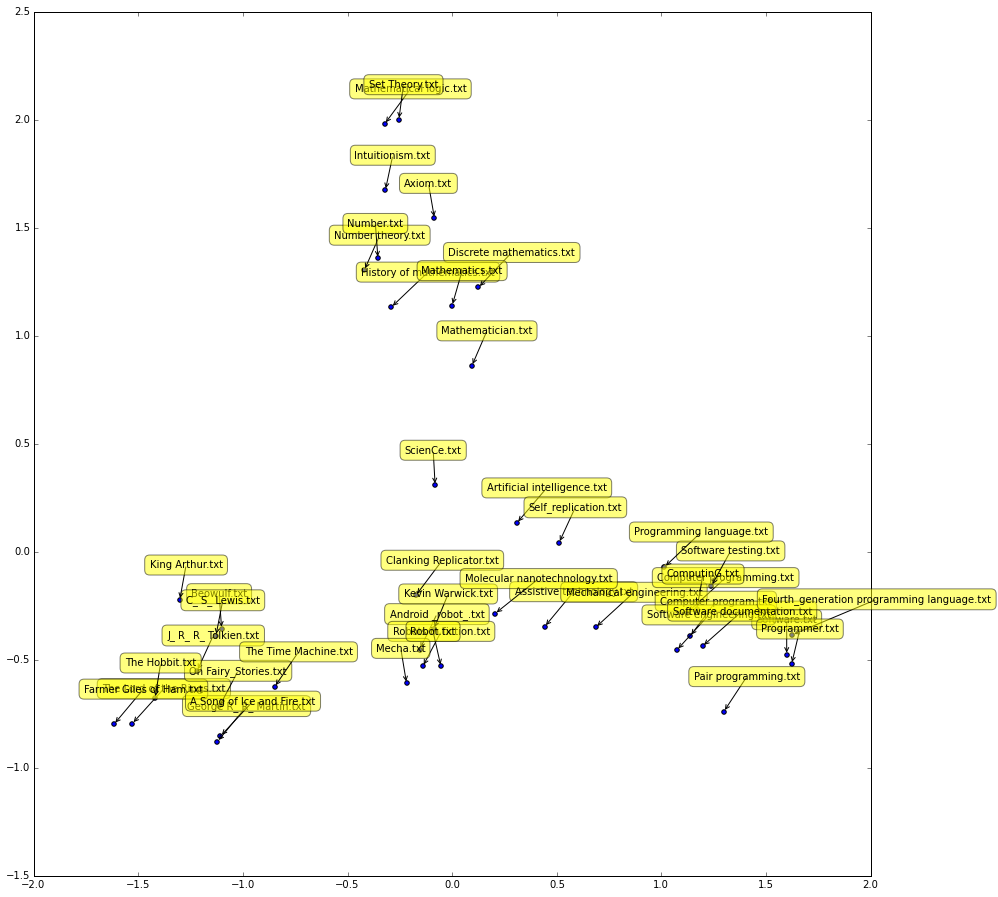

In [34]:
import numpy as np
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *
from scipy import *


df_m = pd.DataFrame(model.docvecs.most_similar('Mathematics.txt', topn=10), columns = ['Documents', 'Similarity'])
df_m.loc[len(df_m)] = ['Mathematics.txt', 2]
df_m[:3]
df_r = pd.DataFrame(model.docvecs.most_similar('Robot.txt', topn=10), columns = ['Documents', 'Similarity'])
df_r.loc[len(df_r)] = ['Robot.txt', 2]
df_r[:3]
df_h = pd.DataFrame(model.docvecs.most_similar('The Hobbit.txt', topn=10), columns = ['Documents', 'Similarity'])
df_h.loc[len(df_h)] = ['The Hobbit.txt', 2]
df_h[:3]
df_p = pd.DataFrame(model.docvecs.most_similar('Programmer.txt', topn=10), columns = ['Documents', 'Similarity'])
df_p.loc[len(df_p)] = ['Programmer.txt', 2]
df_p[:3]
df = pd.concat([df_m, df_r, df_h, df_p])
df.index = range(len(df))
vec = []
for i in xrange(len(df)):
    vec.append(model.docvecs[df.loc[i, "Documents"]])
    

pca = PCA(n_components=2)
vec_2 = pca.fit_transform(vec)


N = 10
data = vec_2
labels = df.Documents.values
plt.figure(figsize=(15,15))
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    data[:, 0], data[:, 1], marker = 'o', 
    cmap = plt.get_cmap('Spectral'))
for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

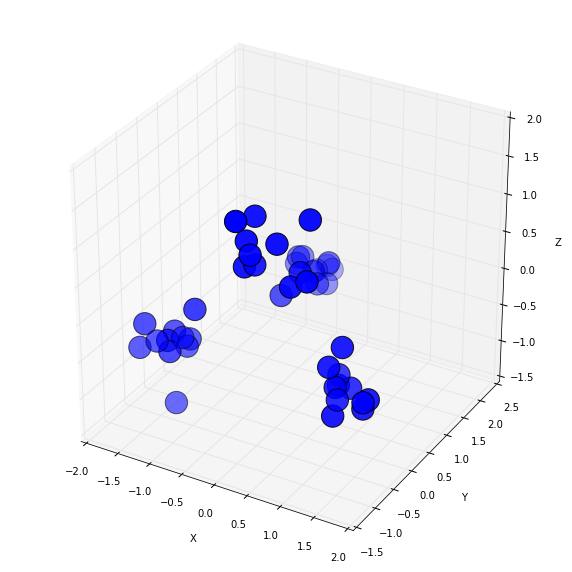

In [35]:
pca = PCA(n_components=3)
vec_3 = pca.fit_transform(vec)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = [v[0] for v in vec_3]
y = [v[1] for v in vec_3]
z = [v[2] for v in vec_3]

ax.scatter(x, y, z, c='b', marker='o', s = 500)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.show()

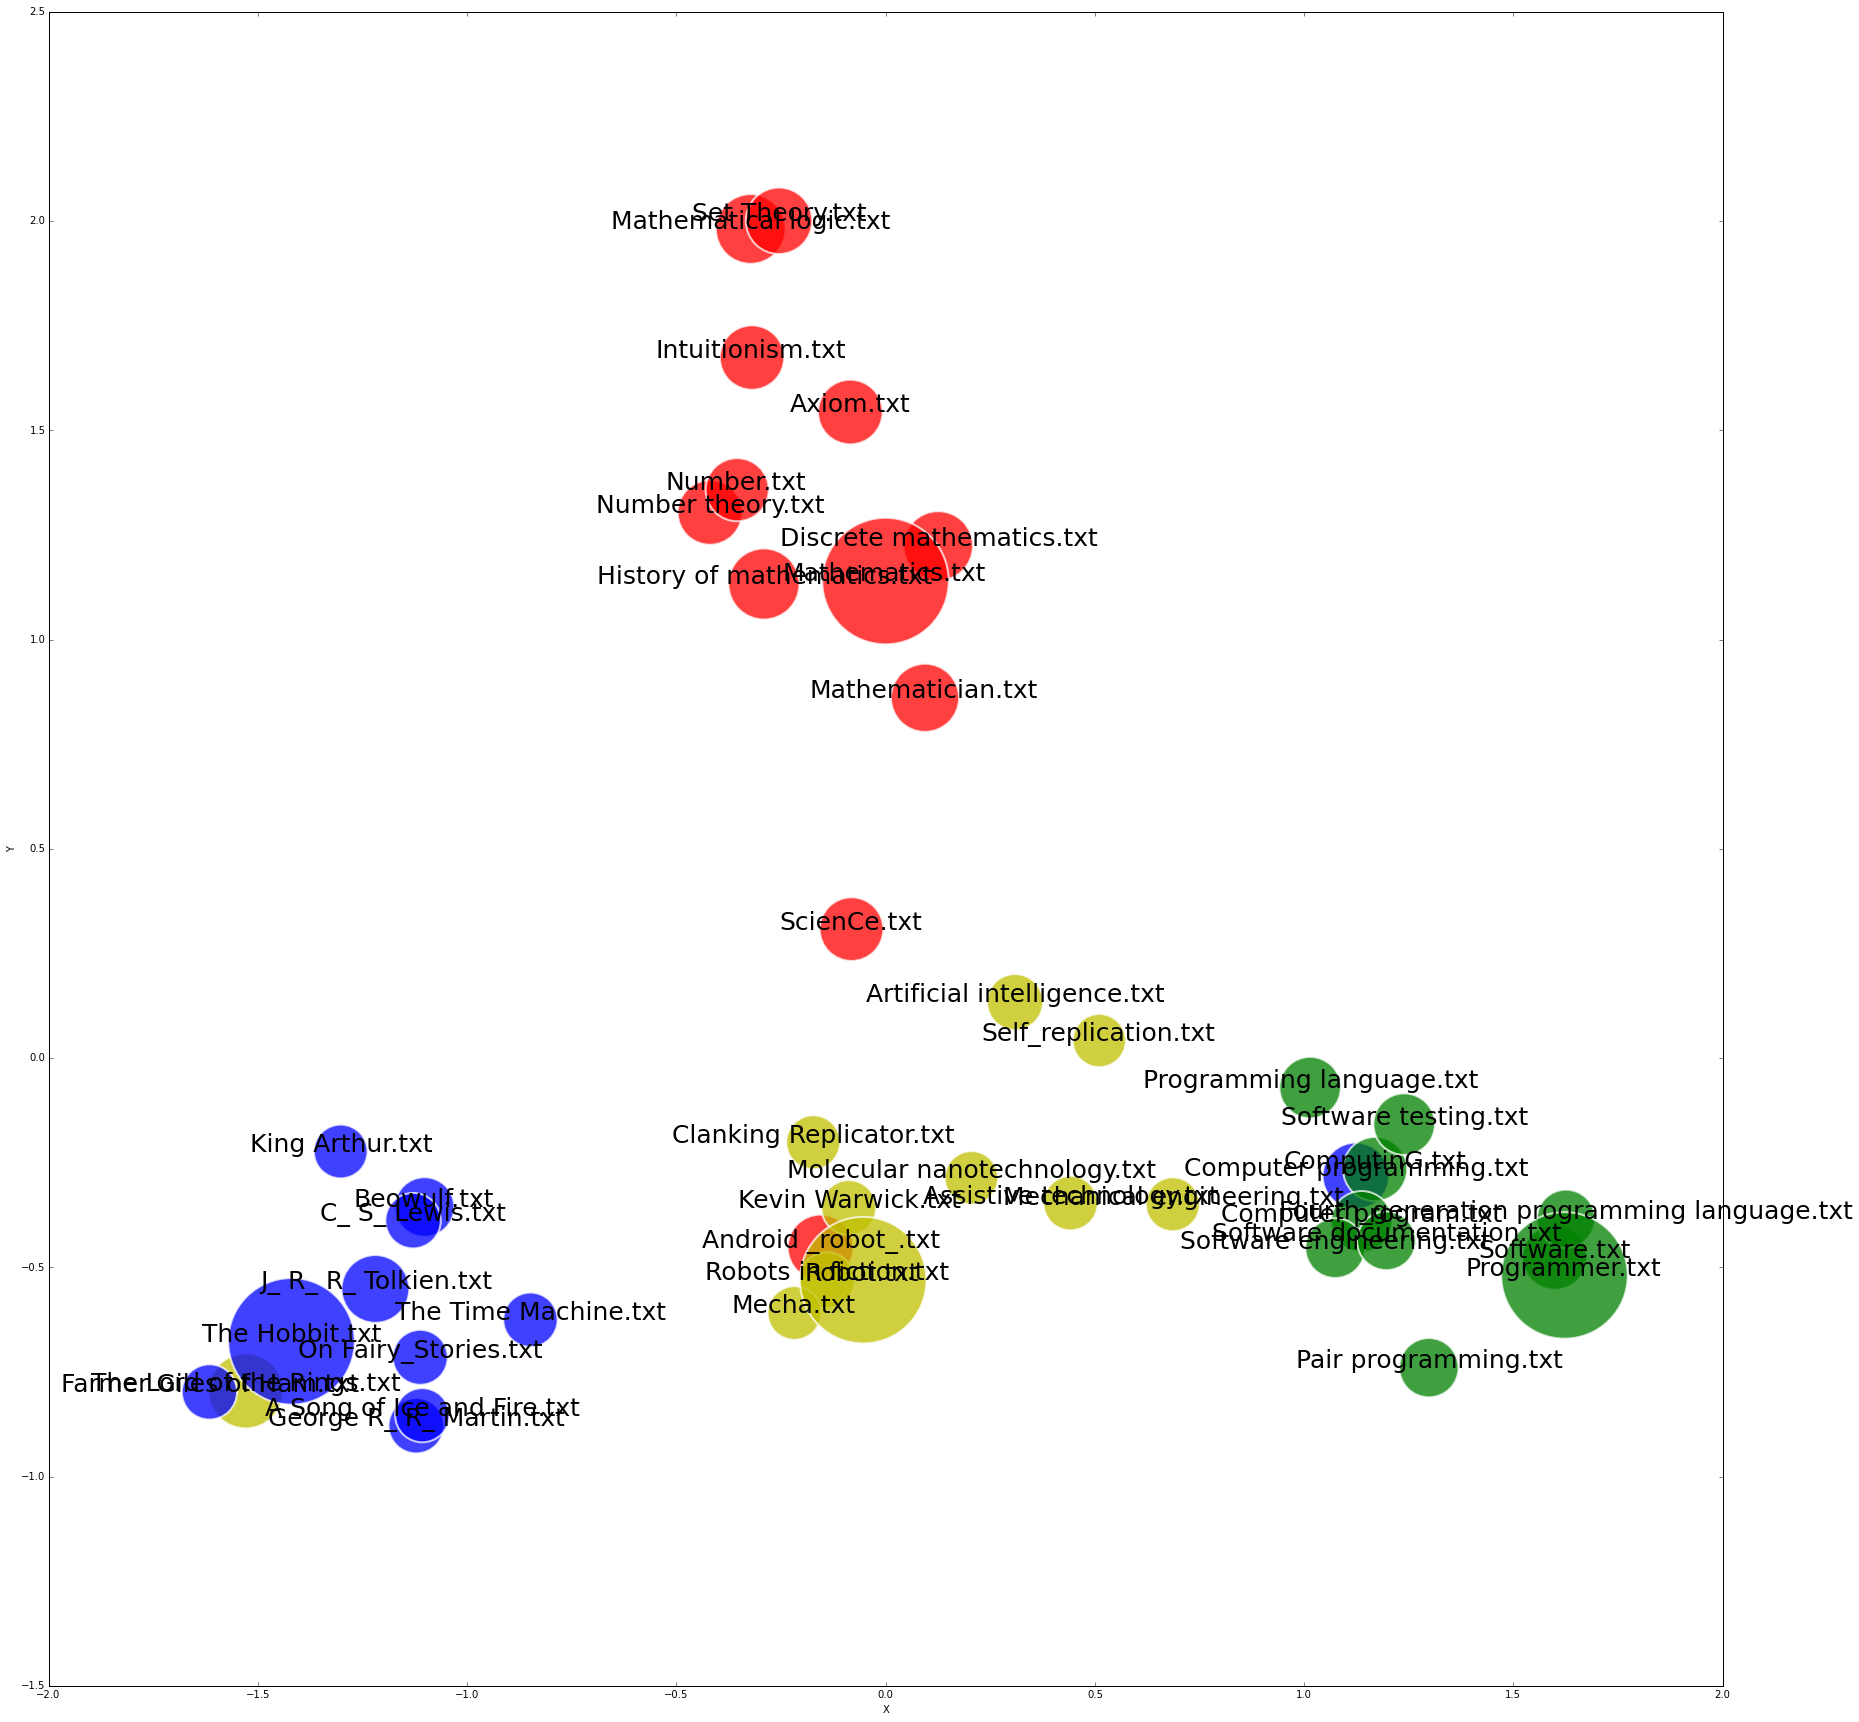

In [36]:
vec_4 = []
for i in xrange(len(df)):
    c = "r"
    if float(i)/11.0 > 3:
        c = "g"
    elif float(i)/11.0 > 2:
        c = "b"
    elif float(i)/11.0 > 1:
        c = "y"    
    vec_4.append([vec_2[i][0], vec_2[i][1], df.Similarity[i], df.Documents[i], c])    
    
x = []
y = []
color = []
area = []

plt.figure(figsize=(30,30))

for data in vec_4:
 x.append(data[0]) 
 y.append(data[1]) 
 color.append(data[4]) 
 area.append((data[2])*8000) 
 # plotting the first eigth letters of the state's name
 text(data[0], data[1], 
      data[3],size=25,horizontalalignment='center')

# making the scatter plot
sct = scatter(x, y, c=color, s=area, linewidths=2, edgecolor='w')

sct.set_alpha(0.75)


xlabel('X')
ylabel('Y')
show()